## Домашнее задание №1

В этом домашнем задании вы познакомитесь с pytorch сами и сможете попрактиковаться в его применении. 

#### План:

1. Простейшие операции в pytorch
2. Пишем Adam и применяем его к ручной модели
3. Обучаем свою первую нейросеть

In [2]:
import os
import sys
import math
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import clear_output

from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

%matplotlib inline
device = 'cuda'
torch.cuda.is_available()

True

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

### Простейшие операции на pytorch (2 балла)

**Task**: Cоздайте два случайных тензора (двумерных, не квадратных):

In [4]:
x = torch.randn((5, 4)) 
y = torch.randn((4, 2))
print('X = ', x, ' \n\n Y = ', y)

X =  tensor([[-1.1258, -1.1524, -0.2506, -0.4339],
        [ 0.5988, -1.5551, -0.3414,  1.8530],
        [ 0.4681, -0.1577,  1.4437,  0.2660],
        [ 1.3894,  1.5863,  0.9463, -0.8437],
        [ 0.9318,  1.2590,  2.0050,  0.0537]])  

 Y =  tensor([[-0.8920, -1.5091],
        [ 0.3704,  1.4565],
        [ 0.9398,  0.7748],
        [ 0.1919,  1.2638]])


**Task**: Умножьте их друг на друга, результат запишите в третий тензор без использования оператора `=`, для создания третьего тензора предлагается использовать `torch.empty`:

In [5]:
size_z = torch.matmul(x,y).size()
z = torch.empty(size_z[0], size_z[1])  
torch.matmul(x, y, out=z)
print('Z = ', z)

Z =  tensor([[ 0.2587, -0.7219],
        [-1.0754, -1.0914],
        [ 0.9319,  0.5187],
        [ 0.0757, -0.1192],
        [ 1.5298,  2.0490]])


**Task**: Реализуйте ReLU использую только pytorch, примените его к тензору `x` (запрещено использование модулей torch.nn и его подмодулей, а также функции torch.relu)

Линейный выпрямитель или Полулинейный элемент (ReLU)

$$
f(x) = 
\begin{cases}
 & 0, x < 0 \\ 
 & x , x \geq 0 
\end{cases}
$$

In [6]:
def relu_forward(x):
    ret = torch.max(torch.zeros_like(x), x)
    return ret

assert torch.all(F.relu(x) == relu_forward(x))

In [7]:
relu_forward(x)

tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.5988, 0.0000, 0.0000, 1.8530],
        [0.4681, 0.0000, 1.4437, 0.2660],
        [1.3894, 1.5863, 0.9463, 0.0000],
        [0.9318, 1.2590, 2.0050, 0.0537]])

**Task**: Сделайте тоже самое c ELU (запрещено использование модулей torch.nn и его подмодулей):

Экспоненциальная линейная функция (ELU)

$$
f(\alpha,x) = 
\begin{cases}
 & \alpha(e^x - 1 ), x < 0 \\ 
 & x , x \geq 0 
\end{cases}
$$

In [8]:
def elu_forward(x, alpha = 1.0):
    first_condition = torch.min(torch.zeros_like(x), alpha * (torch.exp(x) - 1)) # x < 0
    second_condition = torch.max(torch.zeros_like(x), x) # x >= 0
    ret = first_condition + second_condition
    return ret

assert torch.allclose(
    F.elu(x),
    elu_forward(x), 
    1e-4
)

In [9]:
elu_forward(x)

tensor([[-0.6756, -0.6841, -0.2216, -0.3520],
        [ 0.5988, -0.7888, -0.2892,  1.8530],
        [ 0.4681, -0.1459,  1.4437,  0.2660],
        [ 1.3894,  1.5863,  0.9463, -0.5699],
        [ 0.9318,  1.2590,  2.0050,  0.0537]])

**Task**: LeakyReLU (запрещено использование модулей torch.nn и его подмодулей):

Линейный выпрямитель с «утечкой» (Leaky ReLU)

$$
f(x) = 
\begin{cases}
 & 0.01x, x < 0 \\ 
 & x , x \geq 0 
\end{cases}
$$

In [10]:
def lrelu_forward(x, alpha):
  first_condition = torch.min(torch.zeros_like(x), alpha * x) # x < 0
  second_condition = torch.max(torch.zeros_like(x), x) # x >= 0
  ret = first_condition + second_condition
  return ret

assert torch.all(F.leaky_relu(x, 0.01) == lrelu_forward(x, 0.01))

In [11]:
lrelu_forward(x=x, alpha=0.01)

tensor([[-1.1258e-02, -1.1524e-02, -2.5058e-03, -4.3388e-03],
        [ 5.9884e-01, -1.5551e-02, -3.4136e-03,  1.8530e+00],
        [ 4.6810e-01, -1.5771e-03,  1.4437e+00,  2.6605e-01],
        [ 1.3894e+00,  1.5863e+00,  9.4630e-01, -8.4368e-03],
        [ 9.3183e-01,  1.2590e+00,  2.0050e+00,  5.3737e-02]])

**Task**: Теперь перейдем к немного более современным функциям активаций, например Mish, напомним как она выглядит:

$$x * tanh(ln(1+e^x))$$

(запрещено использование модулей torch.nn и его подмодулей)

In [12]:
def mish(x):
    return x * torch.tanh(torch.log(1 + torch.exp(x)))

In [13]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.8651, 0.8651, 0.8651]), 
    atol=1e-4
)

assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64), 
    atol=1e-4
)

**Task**: Теперь реализуем swish, напомним как она выглядит:

$$x * \sigma(x)$$

(запрещено использование модулей torch.nn и его подмодулей)

In [14]:
def swish(x):
    return x * torch.sigmoid(x)

In [15]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.7311, 0.7311, 0.7311]), 
    atol=1e-4
)

assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64), 
    atol=1e-4
)

### Пишем Adam и применяем его к линейной регрессии (4 балла)


В данной секции вам нужно сделать две вещи: 

1. Написать свой собственный оптимизатор подобно тому, который мы писали на семинаре
2. Обучить логистическую регрессию побатчево на картинках из датасета 


#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [16]:
# абстрактный класс, не обращайте внимания
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

**Task**: Напишите свою реализацию Adam:

In [17]:
class Adam(InClassOptimizer):
    def __init__(self, params, lr=0.001, eps=1e-13, beta_1=0.9, beta_2=0.999):
        defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2)
        super().__init__(params, defaults)
        self.t = 0

    def _group_step(self, group):
        lr = group['lr']
        eps = group['eps']
        beta_1 = group['beta_1']
        beta_2 = group['beta_2']
        self.t += 1
        for param in filter(lambda x: x.grad is not None, group['params']):
            self._init_adam_buffer(param)
            param_grad = param.grad
            m_buffer, v_buffer = self._get_adam_buffer(param)
            m_buffer.mul_(beta_1) 
            m_buffer.add_((1 - beta_1) * param_grad)
            v_buffer.mul_(beta_2)
            v_buffer.add_((1 - beta_2) * (param_grad ** 2))
            m_lid = m_buffer / (1 - beta_1 ** self.t)
            v_lid = v_buffer / (1 - beta_2 ** self.t)
            w = m_lid / (torch.sqrt(v_lid) + eps)
            param.add_(w, alpha=-lr)
            

    def _get_adam_buffer(self, param):
        param_state = self.state[param]
        return param_state['adam_m_buffer'], param_state['adam_v_buffer']

    def _init_adam_buffer(self, param):
        param_state = self.state[param]
        if 'adam_m_buffer' not in param_state:
            param_state['adam_m_buffer'] = torch.zeros_like(param)
        if 'adam_v_buffer' not in param_state:
            param_state['adam_v_buffer'] = torch.zeros_like(param)

**Task**: Создайте параметры для обучения линейной регрессии, сделаем Xavier ициализацию, которая выглядит следующим образом: 

$$w \sim U\left[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}\right]$$

где: 

* $n_{in}$ -- размер входа (в нейронах) 
* $n_{out}$ -- размер выхода (в нейронах)

Подумайте над выбором $n_{in}$ и $n_{out}$ самостоятельно. 

Целью инициализации веса является предотвращение взрыва или исчезновения выходных сигналов активации слоя в ходе прямого прохода через глубокую нейронную сеть. Если это произойдет, градиенты потерь будут либо слишком большими, либо слишком маленькими для того, чтобы выгодно течь в обратном направлении, и сети потребуется больше времени для схождения, если она вообще сможет это сделать.

In [18]:
n_in, n_out = (28*28, 10) # на вход будем подавать размер картинки 28*28, а на выходе - кол-во классов - 10
weights = torch.Tensor(n_in, n_out).uniform_(-1, 1)*math.sqrt(6./(n_in + n_out))
intercept = torch.Tensor(1, n_out).uniform_(-1, 1)*math.sqrt(6./(n_in + n_out))
intercept.requires_grad = True
weights.requires_grad = True
bias = intercept

In [19]:
optimizer = Adam([weights, intercept])
loss = nn.CrossEntropyLoss()

Загрузим данные и создадим даталоадеры:

In [20]:
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader = DataLoader(fashion_mnist_train, batch_size=128, shuffle=True,
                              num_workers=1)

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

eval_dataloader = DataLoader(fashion_mnist_eval, batch_size=128, num_workers=1)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Напишите функцию для тренировки логистической регрессии, она должна: 

    * Делать предсказания 
    * Считать лосс 
    * Подсчитывать градиенты
    * Делать шаг оптимизации
    * Обнулять посчитанные градиенты
    * Считать метрики 
    * Возвращать полученные метрики
    
После этого предусмотрите возможность визуализировать метрики, чтобы нарисовать картинки, а именно от вас требуется визуализировать: 

    * Зависимость лосса от количества итераций
    * Зависимость доли правильных ответов от количества итераций

In [21]:
def train_logistic_regression(weights, bias, batch, loss, optimizer):
    y_predict, x_predict = batch
    outputs = torch.matmul(y_predict.view(-1, 1*28*28), weights) + bias

    batch_loss = loss(outputs, x_predict)
    batch_loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == x_predict).sum().item() / len(x_predict)
    return batch_loss, accuracy

In [22]:
def test_logistic_regression(weights, bias, eval_dataloader, loss):
    eval_loss = []
    eval_accuracy = []
    with torch.no_grad():
      for batch in eval_dataloader:
          outputs, labels = batch
          outputs = torch.matmul(outputs.view(-1, 1*28*28), weights) + bias

          batch_loss = loss(outputs, labels).detach().numpy()
          _, predicted = torch.max(outputs, 1)
          
          accuracy = (predicted == labels).sum().item() / len(labels)
          eval_loss.append(batch_loss)
          eval_accuracy.append(accuracy)
      return np.sum(eval_loss) / len(eval_dataloader), np.sum(eval_accuracy) / len(eval_dataloader)

In [23]:
train_scores = {'loss': [],
                 'accuracy': [], 
                 'epoch_num': [], 
                 'accuracy_train_mean_epoch': [],
                 'loss_train_mean_epoch': [],
                 'accuracy_validation_mean_epoch': [], 
                 'loss_validation_mean_epoch': []}

for epoch in range(1, 100):
    for batch in train_dataloader:
        metrics = train_logistic_regression(weights, bias, batch, loss, optimizer)

        train_scores['loss'].append(metrics[0].detach().numpy())
        train_scores['accuracy'].append(metrics[1])
        train_scores['epoch_num'].append(epoch)

    losses = np.array(train_scores['loss'])
    accuracy = np.array(train_scores['accuracy'])
    epoch_nums = np.array(train_scores['epoch_num'])

    avg_accuracy_epoch = np.sum(accuracy[epoch_nums == epoch]) / len(train_dataloader)
    avg_loss_epoch = np.sum(losses[epoch_nums == epoch]) / len(train_dataloader)
    test_loss, test_accuracy = test_logistic_regression(weights, bias, eval_dataloader, loss)

    train_scores['accuracy_validation_mean_epoch'].extend([test_accuracy] * len(train_dataloader))
    train_scores['loss_validation_mean_epoch'].extend([test_loss] * len(train_dataloader))
    train_scores['accuracy_train_mean_epoch'].extend([avg_accuracy_epoch] * len(train_dataloader))
    train_scores['loss_train_mean_epoch'].extend([avg_loss_epoch] * len(train_dataloader))

    print('Epoch: {0} \n loss_train_mean = {1:.4f}, accuracy_train_mean = {2:.4f} \n loss = {3:.4f}, accuracy = {4:.4f}'
    .format(epoch, avg_loss_epoch, avg_accuracy_epoch, test_loss, test_accuracy))

Epoch: 1 
 loss_train_mean = 0.7399, accuracy_train_mean = 0.7566 
 loss = 0.5717, accuracy = 0.8074
Epoch: 2 
 loss_train_mean = 0.5146, accuracy_train_mean = 0.8290 
 loss = 0.5174, accuracy = 0.8249
Epoch: 3 
 loss_train_mean = 0.4733, accuracy_train_mean = 0.8408 
 loss = 0.4879, accuracy = 0.8330
Epoch: 4 
 loss_train_mean = 0.4519, accuracy_train_mean = 0.8477 
 loss = 0.4720, accuracy = 0.8369
Epoch: 5 
 loss_train_mean = 0.4375, accuracy_train_mean = 0.8510 
 loss = 0.4651, accuracy = 0.8377
Epoch: 6 
 loss_train_mean = 0.4279, accuracy_train_mean = 0.8543 
 loss = 0.4619, accuracy = 0.8414
Epoch: 7 
 loss_train_mean = 0.4202, accuracy_train_mean = 0.8565 
 loss = 0.4658, accuracy = 0.8339
Epoch: 8 
 loss_train_mean = 0.4145, accuracy_train_mean = 0.8582 
 loss = 0.4490, accuracy = 0.8443
Epoch: 9 
 loss_train_mean = 0.4090, accuracy_train_mean = 0.8605 
 loss = 0.4491, accuracy = 0.8436
Epoch: 10 
 loss_train_mean = 0.4054, accuracy_train_mean = 0.8607 
 loss = 0.4452, accurac

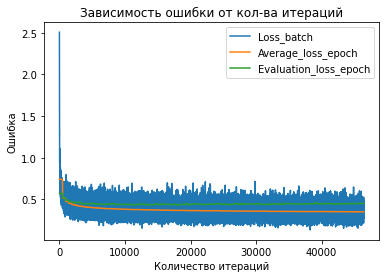

In [24]:
X = np.arange(len(train_scores['loss']))
plt.plot(X, train_scores['loss'], X, train_scores['loss_train_mean_epoch'], X, train_scores['loss_validation_mean_epoch'])
plt.title('Зависимость ошибки от кол-ва итераций')
plt.xlabel('Количество итераций')
plt.ylabel('Ошибка')

plt.legend(['Loss_batch', 'Average_loss_epoch', 'Evaluation_loss_epoch'])

plt.show()

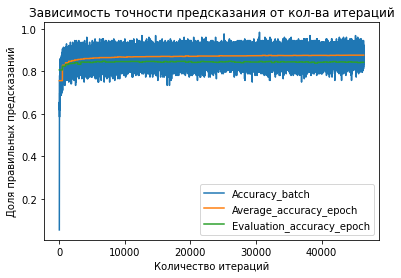

In [25]:
plt.plot(X, train_scores['accuracy'], X, train_scores['accuracy_train_mean_epoch'], X, train_scores['accuracy_validation_mean_epoch'])
plt.title('Зависимость точности предсказания от кол-ва итераций')
plt.xlabel('Количество итераций')
plt.ylabel('Доля правильных предсказаний')

plt.legend(['Accuracy_batch', 'Average_accuracy_epoch', 'Evaluation_accuracy_epoch'])

plt.show()

#### Вопросы к секции: 

* Своими словами и без математики объясните благодаря чему Adam дает несмещенную оценку на квадрат градиента
* Когда модель начала переобучаться? Как вы это поняли? Сделайте визуализацию и докажите свою точку зрения.

#### Ответы к секции: 

* Это происходит, потому что при помощи коррекции смещения и экспоненциального сглаживания,усредняется значение квадрата градиента, что позволяет лучше сходится в необходимом направлении.
* Данная модель не переобучилась, ошибка на валидационной выборке почти не меняется, хотя и составляет немного больше, чем на тестовой. После нескольких эпох, accuracy и ошибка на train стабилизировались и почти не изменялись, а ошибка на валидационной выборке росла.

### Моя первая нейросеть (4 балла)

В данной секции вам нужно сделать следующие вещи: 

* Реализовать три разных архитектуры нейросетей. Эти архитектуры должны принципиально отличаться друг от друга. Разрешается одной из архитекур брать полностью полносвязную модель. Остальные две должны быть сверточными и сильно отличаться друг от друга. К примеру, одна из таких архитектур может быть VGG подобная сеть, а другая ResNet подобная архитектура. 

* Написать цикл для обучения которым можно обучать все три модели без изменений кода

* Попробовать каждую модель с двумя оптимизаторами: RMSprop и SGD with momentum

* Визуализировать результаты перфоманса каждой модели (две метрики минимум для каждого сетапа, например, лосс и долю правильных ответов). В данном пункте мы ждем от вас визуализацию зависимости метрики от номера итерации обучения.

* Сделать выводы какие были модели были лучше и как вы думаете почему?

Будем обучать модели по нарастающей(от самой простой до самой сложной) (от LeNet(1998) до ResNet)

In [26]:
# Функция для получения метрик на валидации
def eval_func(model, eval_dataloader, loss):
    eval_loss = []
    eval_acc = []
    model.eval()
    with torch.no_grad():
      for batch in eval_dataloader:
          inputs, labels = batch
          inputs, labels = inputs.to(device), labels.to(device) 
          outputs = model(inputs)
          batch_loss = loss(outputs, labels).detach().to('cpu').numpy()
          _, predicted = torch.max(outputs, 1)
          accuracy = (predicted == labels).sum().item() / len(labels)
          eval_loss.append(batch_loss)
          eval_acc.append(accuracy)
      return np.sum(eval_loss) / len(eval_dataloader), np.sum(eval_acc) / len(eval_dataloader)

In [27]:
def train_model(model, train_dataloader ,optimizer, epochs):
    # Loss
    loss_function = nn.CrossEntropyLoss()

    # Optimizer
    if optimizer == 'Adam':
      optimizer = torch.optim.Adam(model.parameters())
    elif optimizer == 'RMSprop':
      optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)
    elif optimizer == 'SGD':
      optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    else:
      raise NotImplementedError()
    
    # Training
    loss_history = {'loss': [], # значение ошибки на каждом тренировочном батче
                    'accuracy': [], # точность предсказания на тренировочном батче
                    'epoch_num': [], # номер эпохи
                    'accuracy_train_mean_epoch': [], # среднее accuracy_train для эпохи
                    'loss_train_mean_epoch': [], # среднее loss_train для эпохи
                    'accuracy_validation_mean_epoch': [], # среднее accuracy_validation эпохи
                    'loss_validation_mean_epoch': []} # среднее loss_validation для эпохи

    len_dataloader = len(train_dataloader)
    for epoch in range(epochs):

        total_loss = 0.0
        progress = tqdm(enumerate(train_dataloader), desc='Loss: ', total=len_dataloader)
        model.train()

        for i, batch in progress:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device) 
            optimizer.zero_grad()
            outputs = model(inputs) 
            loss = loss_function(outputs, labels) 
            loss.backward() 
            optimizer.step() 


            current_loss = loss.item()
            total_loss += current_loss

            # Сохраним данные за батч
            with torch.no_grad():
              # Loss
              loss_history['loss'].append(current_loss)
              _, predicted = torch.max(outputs, 1)
              accuracy = (predicted == labels).sum().item() / len(labels)
              # Accuracy
              loss_history['accuracy'].append(accuracy)
              # Epoch_num
              loss_history['epoch_num'].append(epoch)
            
            # Прогресс обучения
            if (i % 100) == 99:
              progress.set_description("Loss: {:.4f}".format(total_loss / 100))
              total_loss = 0.0
           

        torch.cuda.empty_cache()
        
        # Сохраним данные за эпоху
        losses = np.array(loss_history['loss'], dtype='float16')
        accuracy = np.array(loss_history['accuracy'], dtype='float16')
        epoch_nums = np.array(loss_history['epoch_num'], dtype='float16')

        avg_accuracy_epoch = np.sum(accuracy[epoch_nums == epoch]) / len_dataloader
        avg_loss_epoch = np.sum(losses[epoch_nums == epoch]) / len_dataloader
        eval_loss, eval_accuracy = eval_func(model, eval_dataloader, loss_function)

        loss_history['accuracy_validation_mean_epoch'].extend([eval_accuracy] * len_dataloader)
        loss_history['loss_validation_mean_epoch'].extend([eval_loss] * len_dataloader)
        loss_history['accuracy_train_mean_epoch'].extend([avg_accuracy_epoch] * len_dataloader)
        loss_history['loss_train_mean_epoch'].extend([avg_loss_epoch] * len_dataloader)

        print('Epoch: {}, Accuracy_train: {:.4f}, Loss_train: {:.4f}, Accuracy_val: {:.4f}, Loss_val: {:.4f}'. format(epoch, avg_accuracy_epoch, avg_loss_epoch, eval_accuracy, eval_loss))
    if (epoch + 1) == epochs:
        clear_output()
        print('Обучение завершено!!!\nAccuracy_train: {:.4f}, Loss_train: {:.4f}, Accuracy_val: {:.4f}, Loss_val: {:.4f}'. format(avg_accuracy_epoch, avg_loss_epoch, eval_accuracy, eval_loss))

    return loss_history

In [28]:
# Полносвязная модель
first_model = torch.nn.ModuleDict({
    # your code here
    'flt': nn.Flatten(),
    'fc1': nn.Linear(1*28*28, 100),
    'rl1': nn.ELU(), 
    'fc5': nn.Linear(100, 10),
})

class FirstModel(nn.Module):
    def __init__(self):
        super(FirstModel, self).__init__()
        self.model = first_model

    def forward(self, x):
        x = self.model['flt'](x)
        x = self.model['fc1'](x)
        x = self.model['rl1'](x)
        x = self.model['fc5'](x)
        return x

In [29]:
# Полносвязнная модель

mnist_net = FirstModel()
mnist_net.to(device)

mnist_history_RMSprop = train_model(mnist_net, train_dataloader, optimizer='RMSprop', epochs=50)

Обучение завершено!!!
Accuracy_train: 0.8902, Loss_train: 0.3076, Accuracy_val: 0.8722, Loss_val: 0.3686


In [30]:
# Полносвязнная модель

mnist_net = FirstModel()
mnist_net.to(device)

mnist_history_SGD = train_model(mnist_net, train_dataloader, optimizer='SGD', epochs=50)

Обучение завершено!!!
Accuracy_train: 0.9254, Loss_train: 0.2070, Accuracy_val: 0.8861, Loss_val: 0.3336


### Вторая модель будет Lenet


Рассмотрим Lenet в двух версиях, первая - оригинальная, вторая - немного модифицированная, и заодно посмотрим, какая лучше работает.

In [31]:
lenet_model_old = torch.nn.ModuleDict({
    'conv1': torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
    'act1': torch.nn.Tanh(),
    'pool1': torch.nn.AvgPool2d(kernel_size=2, stride=2),

    'conv2': torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0),
    'act2': torch.nn.Tanh(),
    'pool2': torch.nn.AvgPool2d(kernel_size=2, stride=2 ),

    'fc1': torch.nn.Linear(5 * 5 * 16, 120),
    'act3': torch.nn.Tanh(),

    'fc2': torch.nn.Linear(120, 84),
    'act4': torch.nn.Tanh(),

    'fc3': torch.nn.Linear(84, 10)
})

In [32]:
class SecondModel(torch.nn.Module):
  def __init__(self):
    super(SecondModel, self).__init__()
    self.model = lenet_model_old

  def forward (self, x):
    x = self.model['conv1'](x)
    x = self.model['act1'](x)
    x = self.model['pool1'](x)

    x = self.model['conv2'](x)
    x = self.model['act2'](x)
    x = self.model['pool2'](x)

    x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

    x = self.model['fc1'](x)
    x = self.model['act3'](x)

    x = self.model['fc2'](x)
    x = self.model['act4'](x)

    x = self.model['fc3'](x)
    return x



In [33]:
# LeNet_old + RMSprop

lenet_net_old = SecondModel()
lenet_net_old.to(device)

lenet_old_history_RMSprop = train_model(lenet_net_old, train_dataloader, optimizer='RMSprop', epochs=100)

Обучение завершено!!!
Accuracy_train: 0.9200, Loss_train: 0.2172, Accuracy_val: 0.8972, Loss_val: 0.2882


In [34]:
# LeNet_old + SGD

lenet_net_old = SecondModel()
lenet_net_old.to(device)

lenet_old_history_SGD = train_model(lenet_net_old, train_dataloader, optimizer='SGD', epochs=100)

Обучение завершено!!!
Accuracy_train: 0.9920, Loss_train: 0.0265, Accuracy_val: 0.8961, Loss_val: 0.5272


In [35]:
lenet_model_modern = torch.nn.ModuleDict({
    'conv1_1': torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1),
    'conv1_2': torch.nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, padding=1),
    'act1': torch.nn.ReLU(),
    'bn1': torch.nn.BatchNorm2d(num_features=6),
    'pool1': torch.nn.MaxPool2d(kernel_size=2, stride=2),

    'conv2_1': torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=0),
    'conv2_2': torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=0),
    'act2': torch.nn.ReLU(),
    'bn2': torch.nn.BatchNorm2d(num_features=16),
    'pool2': torch.nn.MaxPool2d(kernel_size=2, stride=2 ),

    'fc1': torch.nn.Linear(5 * 5 * 16, 120),
    'act3': torch.nn.ReLU(),

    'fc2': torch.nn.Linear(120, 84),
    'act4': torch.nn.ReLU(),

    'fc3': torch.nn.Linear(84, 10)
})

In [36]:
class SecondModel_new(torch.nn.Module):
  def __init__(self):
    super(SecondModel_new, self).__init__()
    self.model = lenet_model_modern

  def forward (self, x):
    x = self.model['conv1_1'](x)
    x = self.model['conv1_2'](x)
    x = self.model['act1'](x)
    x = self.model['bn1'](x)
    x = self.model['pool1'](x)

    x = self.model['conv2_1'](x)
    x = self.model['conv2_2'](x)
    x = self.model['act2'](x)
    x = self.model['bn2'](x)
    x = self.model['pool2'](x)

    x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

    x = self.model['fc1'](x)
    x = self.model['act3'](x)

    x = self.model['fc2'](x)
    x = self.model['act4'](x)

    x = self.model['fc3'](x)
    return x



In [37]:
# LeNet_new + RMSprop

lenet_net_new = SecondModel_new()
lenet_net_new.to(device)

lenet_new_history_RMSprop = train_model(lenet_net_new, train_dataloader, optimizer='RMSprop', epochs=50)

Обучение завершено!!!
Accuracy_train: 0.9638, Loss_train: 0.1078, Accuracy_val: 0.8958, Loss_val: 0.3318


In [38]:
# LeNet_new + SGD

lenet_net_new = SecondModel_new()
lenet_net_new.to(device)

lenet_new_history_SGD = train_model(lenet_net_new, train_dataloader, optimizer='SGD', epochs=50)

Обучение завершено!!!
Accuracy_train: 0.9915, Loss_train: 0.0228, Accuracy_val: 0.8977, Loss_val: 0.7133


Третью модель рассмотрим ResNet50


In [39]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [40]:
class ThirdModel(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ThirdModel, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 4 блока
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        self.in_channels = intermediate_channels * 4
        
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

In [41]:
# ResNet + RMSprop

resnet = ThirdModel(block, [3, 4, 6, 3], 1, 10)
resnet.to(device)

resnet_history_RMSprop = train_model(resnet, train_dataloader, optimizer='RMSprop', epochs=50)

Обучение завершено!!!
Accuracy_train: 0.9941, Loss_train: 0.0176, Accuracy_val: 0.8922, Loss_val: 0.8318


In [42]:
# ResNet + SGD

resnet = ThirdModel(block, [3, 4, 6, 3], 1, 10)
resnet.to(device)

resnet_history_SGD = train_model(resnet, train_dataloader, optimizer='SGD', epochs=50)

Обучение завершено!!!
Accuracy_train: 0.9963, Loss_train: 0.0110, Accuracy_val: 0.9118, Loss_val: 0.5736


### Результаты

###Первый график
Зависимость accuracy_train от кол-во итераций

Из-за того, что я ошибся пришлось данные с lenet урезать, так как там было 100 эпох,а все остальные модели обучались на 50 эпохах.

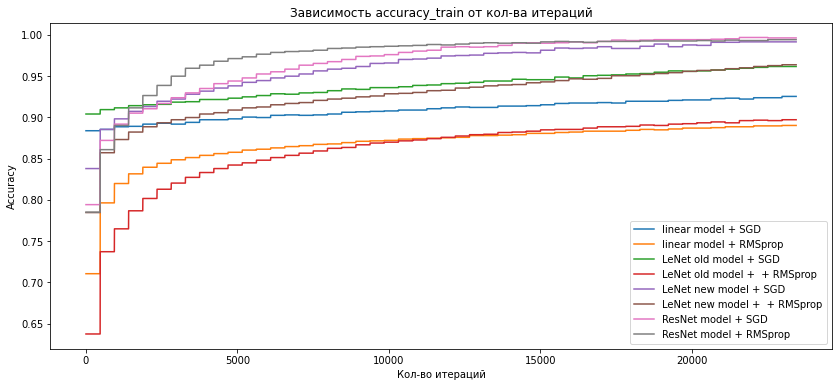

In [59]:
X = np.arange(len(mnist_history_SGD['accuracy_train_mean_epoch']))
plt.figure(figsize=(14,6))
plt.plot(X, mnist_history_SGD['accuracy_train_mean_epoch'], X, mnist_history_RMSprop['accuracy_train_mean_epoch'],
         X, lenet_old_history_SGD['accuracy_train_mean_epoch'][:23450], X, lenet_old_history_RMSprop['accuracy_train_mean_epoch'][:23450],
         X, lenet_new_history_SGD['accuracy_train_mean_epoch'][:23450], X, lenet_new_history_RMSprop['accuracy_train_mean_epoch'][:23450],
         X, resnet_history_SGD['accuracy_train_mean_epoch'], X, resnet_history_RMSprop['accuracy_train_mean_epoch'],
         alpha=1)
plt.title('Зависимость accuracy_train от кол-ва итераций')
plt.xlabel('Кол-во итераций')
plt.ylabel('Accuracy')
plt.legend(['linear model + SGD', 'linear model + RMSprop',
            'LeNet old model + SGD', 'LeNet old model +  + RMSprop',
            'LeNet new model + SGD', 'LeNet new model +  + RMSprop',
            'ResNet model + SGD', 'ResNet model + RMSprop'])

plt.show()

###Второй график
Зависимость accuracy_validation от кол-во итераций

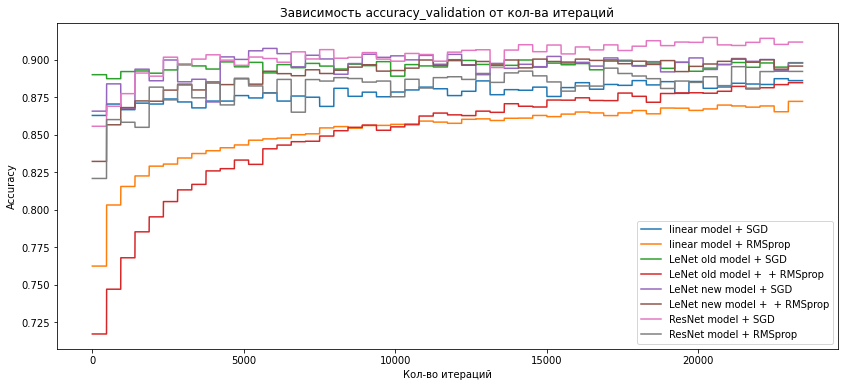

In [57]:
X = np.arange(len(mnist_history_SGD['accuracy_validation_mean_epoch']))
plt.figure(figsize=(14,6))
plt.plot(X, mnist_history_SGD['accuracy_validation_mean_epoch'], X, mnist_history_RMSprop['accuracy_validation_mean_epoch'],
         X, lenet_old_history_SGD['accuracy_validation_mean_epoch'][:23450], X, lenet_old_history_RMSprop['accuracy_validation_mean_epoch'][:23450],
         X, lenet_new_history_SGD['accuracy_validation_mean_epoch'][:23450], X, lenet_new_history_RMSprop['accuracy_validation_mean_epoch'][:23450],
         X, resnet_history_SGD['accuracy_validation_mean_epoch'], X, resnet_history_RMSprop['accuracy_validation_mean_epoch'],
         alpha=1)
plt.title('Зависимость accuracy_validation от кол-ва итераций')
plt.xlabel('Кол-во итераций')
plt.ylabel('Accuracy')
plt.legend(['linear model + SGD', 'linear model + RMSprop',
            'LeNet old model + SGD', 'LeNet old model +  + RMSprop',
            'LeNet new model + SGD', 'LeNet new model +  + RMSprop',
            'ResNet model + SGD', 'ResNet model + RMSprop'])

plt.show()

###Третий график
Зависимость loss_train от кол-ва итераций

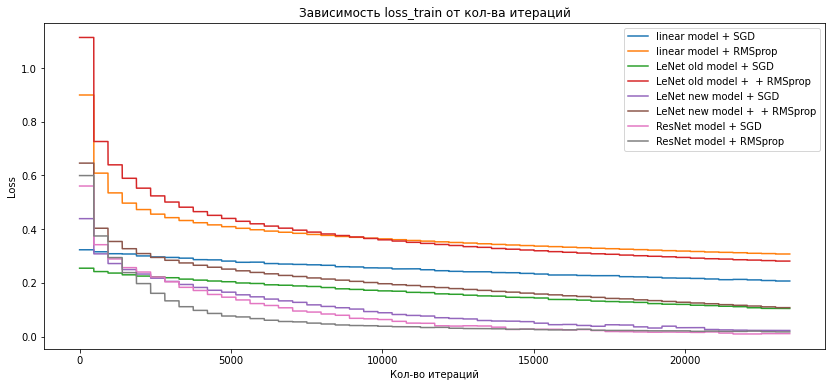

In [58]:
X = np.arange(len(mnist_history_SGD['loss_train_mean_epoch']))
plt.figure(figsize=(14,6))
plt.plot(X, mnist_history_SGD['loss_train_mean_epoch'], X, mnist_history_RMSprop['loss_train_mean_epoch'],
         X, lenet_old_history_SGD['loss_train_mean_epoch'][:23450], X, lenet_old_history_RMSprop['loss_train_mean_epoch'][:23450],
         X, lenet_new_history_SGD['loss_train_mean_epoch'][:23450], X, lenet_new_history_RMSprop['loss_train_mean_epoch'][:23450],
         X, resnet_history_SGD['loss_train_mean_epoch'], X, resnet_history_RMSprop['loss_train_mean_epoch'],
         alpha=1)
plt.title('Зависимость loss_train от кол-ва итераций')
plt.xlabel('Кол-во итераций')
plt.ylabel('Loss')
plt.legend(['linear model + SGD', 'linear model + RMSprop',
            'LeNet old model + SGD', 'LeNet old model +  + RMSprop',
            'LeNet new model + SGD', 'LeNet new model +  + RMSprop',
            'ResNet model + SGD', 'ResNet model + RMSprop'])

plt.show()

###Четвертый график
Зависимость loss_validation от кол-ва итераций

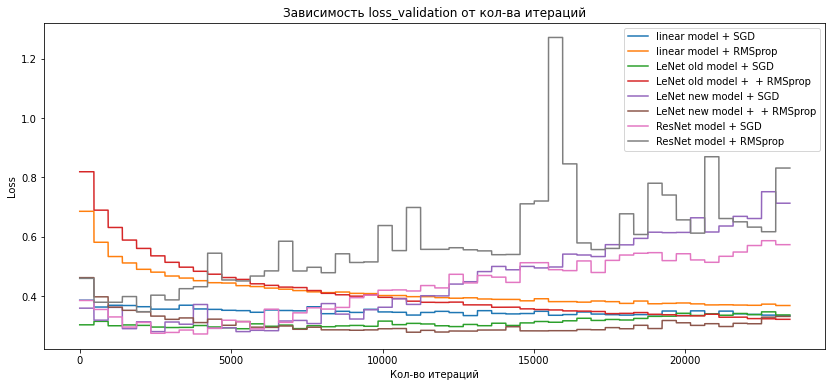

In [60]:
X = np.arange(len(mnist_history_SGD['loss_validation_mean_epoch']))
plt.figure(figsize=(14,6))
plt.plot(X, mnist_history_SGD['loss_validation_mean_epoch'], X, mnist_history_RMSprop['loss_validation_mean_epoch'],
         X, lenet_old_history_SGD['loss_validation_mean_epoch'][:23450], X, lenet_old_history_RMSprop['loss_validation_mean_epoch'][:23450],
         X, lenet_new_history_SGD['loss_validation_mean_epoch'][:23450], X, lenet_new_history_RMSprop['loss_validation_mean_epoch'][:23450],
         X, resnet_history_SGD['loss_validation_mean_epoch'], X, resnet_history_RMSprop['loss_validation_mean_epoch'],
         alpha=1)
plt.title('Зависимость loss_validation от кол-ва итераций')
plt.xlabel('Кол-во итераций')
plt.ylabel('Loss')
plt.legend(['linear model + SGD', 'linear model + RMSprop',
            'LeNet old model + SGD', 'LeNet old model +  + RMSprop',
            'LeNet new model + SGD', 'LeNet new model +  + RMSprop',
            'ResNet model + SGD', 'ResNet model + RMSprop'])

plt.show()

У нас на есть три основные модели:

1.   Простая полносвязная модель
2.   LeNet(1998) оригинальная версия
3.   LeNet немного усовершенствованная версия
4.   ResNet

Для начала сравним LeNet_new и LeNet_old.


*   На *accuracy_train*, LeNet_old + RMSprop показал плохие результаты (долго сходился), остальные почти одинаково сошлись
*   На *accuracy_validation* аналогичная ситуация
*   На *loss_train*, LeNet_old + RMSprop опять показал плохие результаты, зато LeNet_new+SGD лидирует, LeNet_new + RMSprop и LeNet_old + SGD показывают похожие результаты, хотя new+RMSprop думаю при большой итерации быстрее уменьшит loss
*   На *loss_validation*, LeNet_new + SGD очень быстро переобучилась, зато остальные модели более стабильны к переобучению


Отсюда можно сделать вывод, что LeNet_new быстрее сходится, но с SGD возможно быстрое переобучение, поэтому лучше всего использовать RMSprop, так как он более устойчив к нему








График *loss_validation* вынес отдельно, для того чтобы наглядно посмотреть различия между версиями LeNet

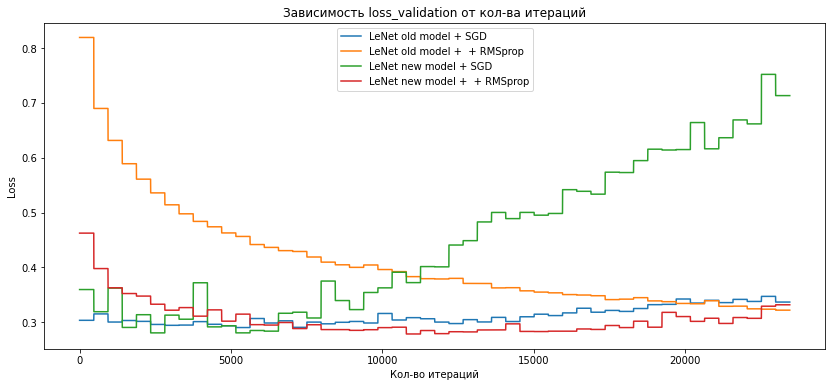

In [61]:
X = np.arange(len(mnist_history_SGD['loss_validation_mean_epoch']))
plt.figure(figsize=(14,6))
plt.plot(
         X, lenet_old_history_SGD['loss_validation_mean_epoch'][:23450], X, lenet_old_history_RMSprop['loss_validation_mean_epoch'][:23450],
         X, lenet_new_history_SGD['loss_validation_mean_epoch'][:23450], X, lenet_new_history_RMSprop['loss_validation_mean_epoch'][:23450],
        
         alpha=1)
plt.title('Зависимость loss_validation от кол-ва итераций')
plt.xlabel('Кол-во итераций')
plt.ylabel('Loss')
plt.legend([
            'LeNet old model + SGD', 'LeNet old model +  + RMSprop',
            'LeNet new model + SGD', 'LeNet new model +  + RMSprop',
            ])

plt.show()

Так же на графиках видно, как ResNet довольно быстро сходится, но имеет быстрое переобучение. ResNet+SGD показал лучшее результаты, быстро сходится и имеет менее выраженное переобучение по сравнению с RMSprop. 



Linear model + SGD показал, лучшее результаты(быстрое схождение,а так же устойчивость к переобучению) по сравнению с RMSprop.